In [ ]:
#'cffex-host-alarm.csv' process code
#Author: 普俊韬
#Last update: 20180626

#导入pandas、numpy库
import pandas as pd
import numpy as np


#TODO：进行原始数据的分割处理

#读取原始数据（GBK编码，数据不带列标题）
data = pd.read_csv('raw_data\cffex-host-alarm.csv',encoding = 'GBK', header = None)

#分割数据字段，分隔符'|||'（'[|]+'),分割后扩展列
data_processed = data[0].str.split('[|]+',expand = True)

#插入列标题
data_processed.columns = ['node_name', 'node_alias', 'component', 'category', 'alarm_count', 'first_time', 'last_time', 'alarm_level', 'alarm_content']


#TODO：进行'component'字段的处理

#将'component'字段提取出来作为一个DataFrame
data_component = data_processed.loc[:,['component']]

#去掉重复数据
data_component_processed = data_component.drop_duplicates()

#插入id列，编号从1开始
data_component_processed['id'] = range(1,len(data_component_processed) + 1)

#将列顺序调整为['id', 'component']
data_component_processed = data_component_processed[['id','component']]

#将处理后结果写入'cffex-host-alarm-component.csv'（不带行标签，GBK编码）
data_component_processed.to_csv('output_data\cffex-host-alarm-component.csv', index = 0, encoding = 'GBK')


#TODO：进行'category'字段的处理

#将'category'字段提取出来作为一个DataFrame
data_category = data_processed.loc[:,['category']]

#去掉重复数据
data_category_processed = data_category.drop_duplicates()

#插入id列，编号从1开始
data_category_processed['id'] = range(1,len(data_category_processed) + 1)

#将列顺序调整为['id', 'category']
data_category_processed = data_category_processed[['id','category']]

#将处理后结果写入'cffex-host-alarm-category.csv'（不带行标签，GBK编码）
data_category_processed.to_csv('output_data\cffex-host-alarm-category.csv', index = 0, encoding = 'GBK')


#TODO：将'component'和'category'字段替换为对应的'id'值，方便后续的数据处理

#对'component'字段进行查找和替换
data_processed['component'] = data_processed['component'].replace(data_component_processed['component'].tolist(),data_component_processed['id'].tolist())

#对'category'字段进行查找和替换
data_processed['category'] = data_processed['category'].replace(data_category_processed['category'].tolist(),data_category_processed['id'].tolist())

#将处理后结果写入'cffex-host-alarm-processed.csv'（不带行标签，GBK编码）
data_processed.to_csv('output_data\cffex-host-alarm-processed.csv', index = 0, encoding = 'GBK')



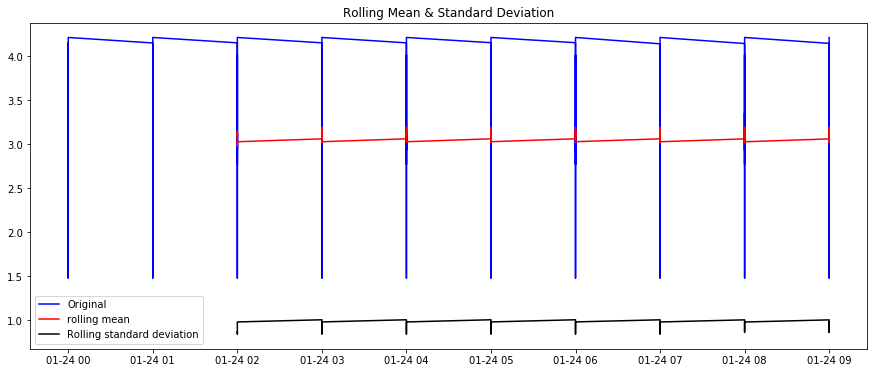

Results of Dickey-Fuller Test:
Test Statistic                 -4.194695
p-value                         0.000673
#Lags Used                     12.000000
Number of Observations Used    87.000000
Critical value (1%)            -3.507853
Critical value (5%)            -2.895382
Critical value (10%)           -2.584824
dtype: float64
ACF-PACF:


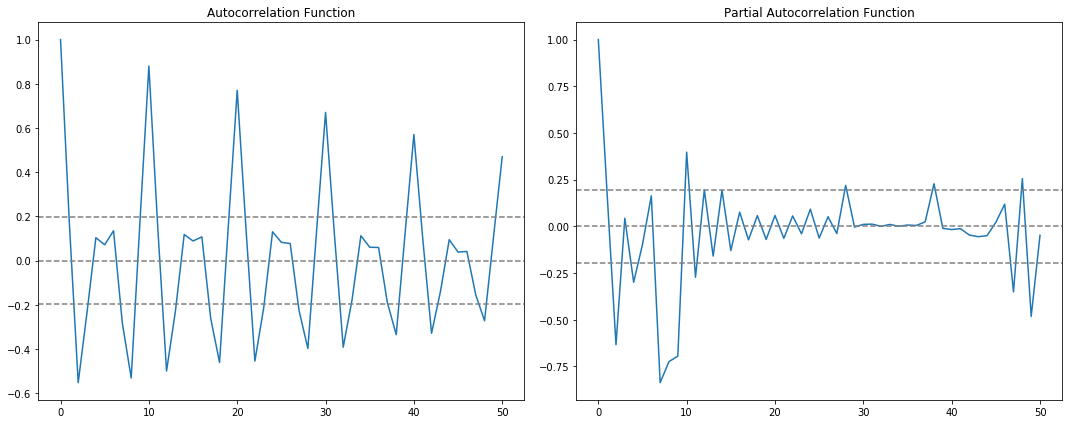

Time Series Decompose:


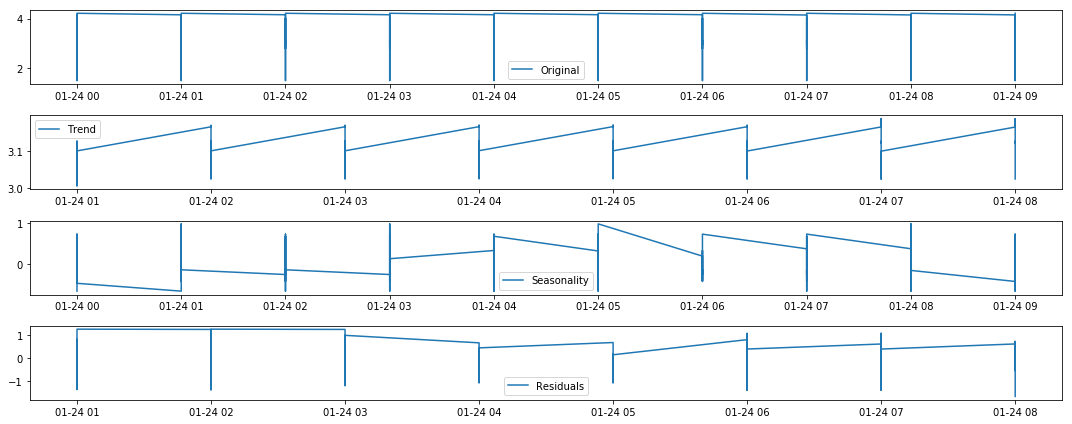

MA(Moving Average):


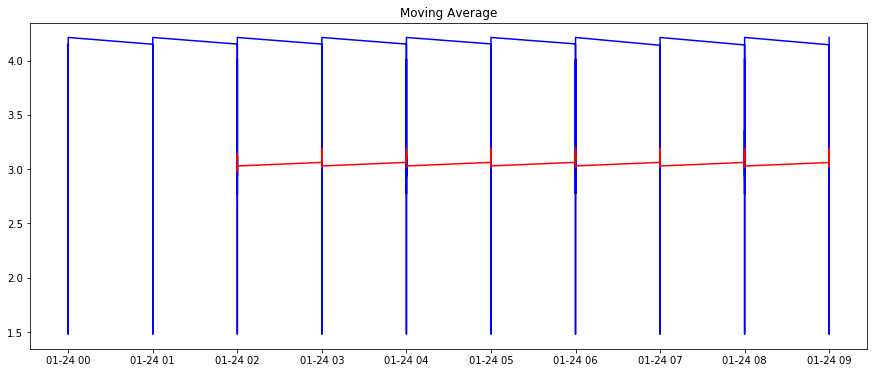

MSE: 3.0796
RMSE: 1.7549
MAE: 1.2776
R-Square: -2.7775
archour
2018-01-24 09:00:00    3.061779
2018-01-24 09:00:00    3.138288
2018-01-24 09:00:00    3.191838
2018-01-24 09:00:00    3.183545
2018-01-24 09:00:00    3.126505
2018-01-24 09:00:00    3.117992
2018-01-24 09:00:00    3.135619
2018-01-24 09:00:00    3.067623
2018-01-24 09:00:00    3.020792
2018-01-24 09:00:00    3.029085
Name: maxvalue, dtype: float64
archour
2018-01-24 09:00:00    4.146304
2018-01-24 09:00:00    3.317816
2018-01-24 09:00:00    2.933857
2018-01-24 09:00:00    4.014580
2018-01-24 09:00:00    2.772589
2018-01-24 09:00:00    3.113515
2018-01-24 09:00:00    3.356897
2018-01-24 09:00:00    1.481605
2018-01-24 09:00:00    1.648659
2018-01-24 09:00:00    4.213608
Name: maxvalue, dtype: float64
ES[1]:


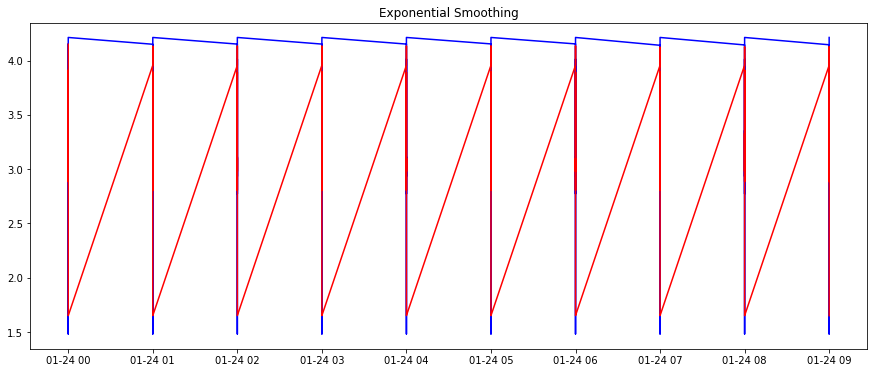

MSE: 1.3172
RMSE: 1.1477
MAE: 0.8288
R-Square: -0.6156
ES[2]:


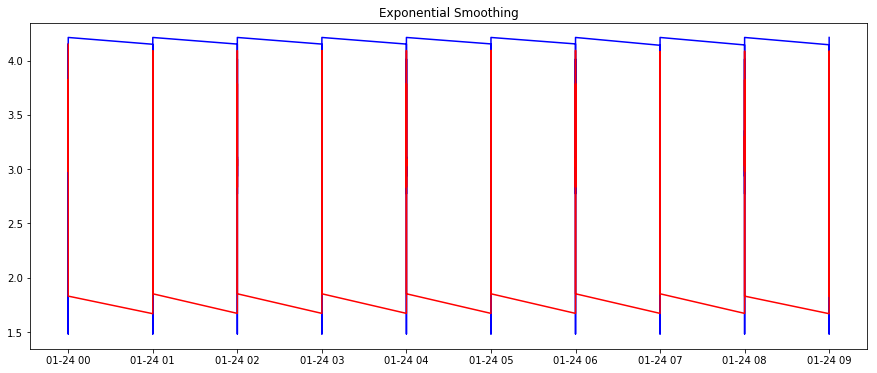

MSE: 2.1516
RMSE: 1.4668
MAE: 1.2072
R-Square: -1.6392
ES_P:


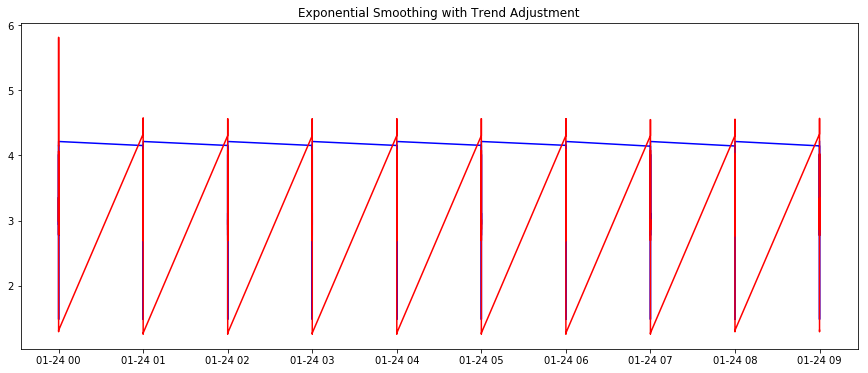

MSE: 1.7580
RMSE: 1.3259
MAE: 1.0077
R-Square: -1.1564
NAIVE:


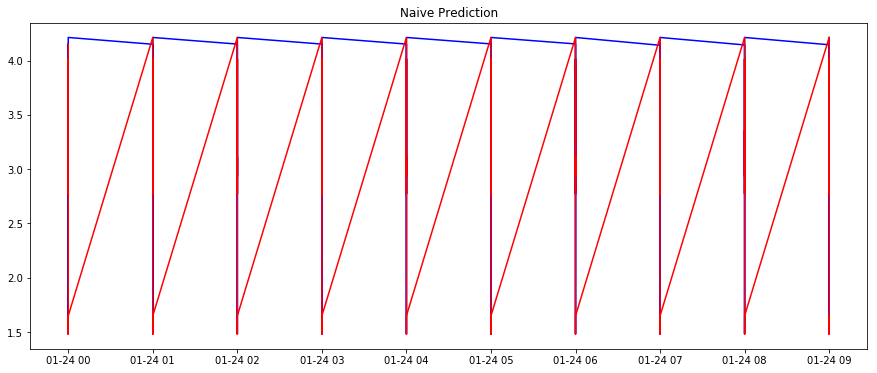

MSE: 1.3320
RMSE: 1.1541
MAE: 0.8446
R-Square: -0.6339
EWMA:


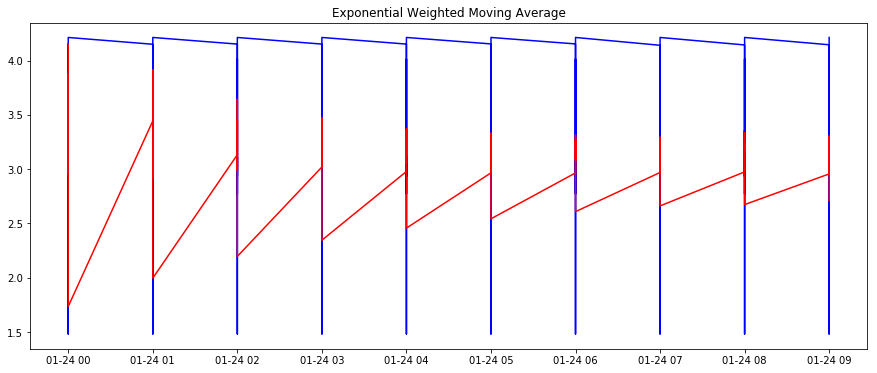

MSE: 1.0667
RMSE: 1.0328
MAE: 0.8013
R-Square: -0.3085


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


rcParams['figure.figsize'] = 15,6

dateparse = lambda dates: pd.datetime.strptime(dates,'%Y%m%d%H')

data = pd.read_csv(r'E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info\2018_config3_hourly_disk.csv',
                   encoding='UTF-8',parse_dates=['archour'],index_col = 'archour',date_parser=dateparse,nrows = 100)


ts_maxvalue = data['maxvalue']
ts_maxvalue_log = np.log(ts_maxvalue)

#168
# 稳定性检测
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window = 24).mean()
    rolstd = timeseries.rolling(window = 24).std()
    
    fig = plt.figure()
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'rolling mean')
    std = plt.plot(rolstd,color = 'black', label = 'Rolling standard deviation')
    
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #dickey-Fuller test:
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key] = value
        
    print (dfoutput)
        
        
        
# 时间序列分解
def decompose(timeseries):
    decomposition = seasonal_decompose(timeseries,freq=24)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.subplot(411)
    plt.plot(ts_maxvalue_log,label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend,label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual,label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    return trend,seasonal,residual

# 时间序列分解调用
# trend,seasonal,residual = decompose(ts_maxvalue_log)
# residual.dropna(inplace=True)
# test_stationarity(residual)


# 自相关、偏自相关图
def ACF_PACF(timeseries):
    lag_acf = acf(timeseries, nlags = 50)
    lag_pacf = pacf(timeseries, nlags = 50, method='ols')

    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    
    plt.show()


# ARIMA模型
def ARIMA_Pre(timeseries,order):
    model = ARIMA(timeseries,order)
    results_ARIMA= model.fit(disp=-1)
    plt.plot(timeseries, color = 'blue')
    plt.plot(results_ARIMA.fittedvalues,color='red')
    plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-timeseries)**2))
    plt.show(block=False)
    
    return results_ARIMA.fittedvalues

# MA模型
def MA(timeseries, ordered_window):
    moving_avg = timeseries.rolling(window = ordered_window).mean()
    plt.plot(timeseries, color = 'blue')
    plt.plot(moving_avg, color = 'red')
    plt.title('Moving Average')
    plt.show(block=False)
    return moving_avg

# ES模型
def ES(alpha, timeseries):
    ES_TS = timeseries.copy(deep=True)
    ES_TS[ES_TS!=0] = 0.0
    ES_TS[0] = timeseries[0]
    for i in range(1, len(ES_TS)):
        ES_TS[i] = alpha*timeseries[i-1]+(1-alpha)*ES_TS[i-1]
    
    plt.plot(ts_maxvalue_log, color = 'blue')
    plt.plot(ES_TS, color = 'red')
    plt.title('Exponential Smoothing')
    plt.show(block=False)
    return ES_TS

def ES_P(alpha, beta, timeseries):
    ES_TS = timeseries.copy(deep=True)
    ES_TS[ES_TS!=0] = 0.0
    ES_TS[0] = timeseries[0]
    ES_Trend = ES_TS.copy(deep=True)
    ES_Final = ES_TS.copy(deep=True)
    for i in range(1, len(ES_TS)):
        ES_TS[i] = alpha*timeseries[i-1] + (1-alpha)*ES_TS[i-1]
        ES_Trend[i] = (1-beta)*ES_Trend[i-1] + beta*(ES_TS[i]-ES_TS[i-1])
        ES_Final[i] = ES_TS[i] + ES_Trend[i]
        
    plt.plot(ts_maxvalue_log, color = 'blue')
    plt.plot(ES_Final, color = 'red')
    plt.title('Exponential Smoothing with Trend Adjustment')
    plt.show(block=False)
    return ES_Final

def EWMA(factor, timeseries):
    EWMA_TS = timeseries.copy(deep=True)
    EWMA_TS[EWMA_TS!=0] = 0.0
    EWMA_TS[0] = timeseries[0]
    for i in range(1, len(EWMA_TS)):
        alpha = factor/(i+factor-1)
        EWMA_TS[i] = alpha*timeseries[i-1]+(1-alpha)*EWMA_TS[i-1]
    
    plt.plot(ts_maxvalue_log, color = 'blue')
    plt.plot(EWMA_TS, color = 'red')
    plt.title('Exponential Weighted Moving Average')
    plt.show(block=False)
    return EWMA_TS

def Naive(timeseries):
    NAIVE_TS = timeseries.copy(deep=True)
    NAIVE_TS[NAIVE_TS!=0] = 0.0
    NAIVE_TS[0] = timeseries[0]
    for i in range(1, len(NAIVE_TS)):
        NAIVE_TS[i] = timeseries[i-1]
    
    plt.plot(ts_maxvalue_log, color = 'blue')
    plt.plot(NAIVE_TS, color = 'red')
    plt.title('Naive Prediction')
    plt.show(block=False)
    return NAIVE_TS
    
# 回归预测评价
def evaluate(timeseries,results):
    print('MSE: %.4f'% mean_squared_error(timeseries,results))
    print('RMSE: %.4f'% (mean_squared_error(timeseries,results))**0.5)
    print('MAE: %.4f'% mean_absolute_error(timeseries,results))
    print('R-Square: %.4f'% r2_score(timeseries,results))
    

# 稳定性检测
test_stationarity(ts_maxvalue_log)

# ACF-PACF
print('ACF-PACF:')
ACF_PACF(ts_maxvalue_log)

# 时间序列分解
print('Time Series Decompose:')
decompose(ts_maxvalue_log)

# MA结果
print('MA(Moving Average):')
MA_results = MA(ts_maxvalue_log, 24)
nan = np.isnan(MA_results)
MA_results[nan] = 0
evaluate(ts_maxvalue_log, MA_results)
print (MA_results[-10:])
print (ts_maxvalue_log[-10:])

# # ARIMA结果
# print('ARIMA:')
# ARIMA_results = ARIMA_Pre(ts_maxvalue_log,(1,1,1))
# evaluate(ts_maxvalue_log, ARIMA_results)

# ES结果
print('ES[1]:')
alpha = .90#设置alphe，即平滑系数
ES_results = ES(alpha,ts_maxvalue_log)
evaluate(ts_maxvalue_log, ES_results)
print('ES[2]:')
ES2_results = ES(alpha, ES_results)
evaluate(ts_maxvalue_log, ES2_results)

# ES_P结果
print('ES_P:')
alpha = .70#设置alphe，即平滑系数
beta = .60#设置beta，即趋势调整系数
ES_P_results = ES_P(alpha,beta,ts_maxvalue_log)
evaluate(ts_maxvalue_log, ES_P_results)

# Naive结果
print('NAIVE:')
NAIVE_results = Naive(ts_maxvalue_log)
evaluate(ts_maxvalue_log, NAIVE_results)

# EWMA结果
print('EWMA:')
factor = 20
EWMA_results = EWMA(factor,ts_maxvalue_log)
evaluate(ts_maxvalue_log, EWMA_results)

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import os, sys, json, csv, re
import pywt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

rcParams['figure.figsize'] = 15,6

# ARIMA模型
def ARIMA(timeseries,order):
    model = ARIMA(timeseries,order)
    results_ARIMA= model.fit(disp=-1)
    return results_ARIMA.fittedvalues

# MA模型
def MA(timeseries, ordered_window):
    moving_avg = timeseries.rolling(window = ordered_window).mean()
    return moving_avg

# ES模型
def ES(alpha, timeseries):
    ES_TS = timeseries.copy(deep=True)
    ES_TS[ES_TS!=0] = 0.0
    ES_TS[0] = timeseries[0]
    for i in range(1, len(ES_TS)):
        ES_TS[i] = alpha*timeseries[i-1]+(1-alpha)*ES_TS[i-1]
    return ES_TS

# 指数平滑趋势调整模型
def ES_P(alpha, beta, timeseries):
    ES_TS = timeseries.copy(deep=True)
    ES_TS[ES_TS!=0] = 0.0
    ES_TS[0] = timeseries[0]
    ES_Trend = ES_TS.copy(deep=True)
    ES_Final = ES_TS.copy(deep=True)
    for i in range(1, len(ES_TS)):
        ES_TS[i] = alpha*timeseries[i-1] + (1-alpha)*ES_TS[i-1]
        ES_Trend[i] = (1-beta)*ES_Trend[i-1] + beta*(ES_TS[i]-ES_TS[i-1])
        ES_Final[i] = ES_TS[i] + ES_Trend[i]
    return ES_Final

# 指数加权平均模型
def EWMA(factor, timeseries):
    EWMA_TS = timeseries.copy(deep=True)
    EWMA_TS[EWMA_TS!=0] = 0.0
    EWMA_TS[0] = timeseries[0]
    for i in range(1, len(EWMA_TS)):
        alpha = factor/(i+factor-1)
        EWMA_TS[i] = alpha*timeseries[i-1]+(1-alpha)*EWMA_TS[i-1]
    return EWMA_TS

# Naive模型
def Naive(timeseries):
    NAIVE_TS = timeseries.copy(deep=True)
    NAIVE_TS[NAIVE_TS!=0] = 0.0
    NAIVE_TS[0] = timeseries[0]
    for i in range(1, len(NAIVE_TS)):
        NAIVE_TS[i] = timeseries[i-1]
    return NAIVE_TS

#小波变换
def Wavelet(timeseries, predictlen):
    index_list = np.array(timeseries)[:-predictlen]
    date_list1 = np.array(timeseries.index)[:-predictlen]

    index_for_predict = np.array(timeseries)[-predictlen:]
    date_list2 = np.array(timeseries.index)[-predictlen:]

    #分解
    A2,D2,D1 = pywt.wavedec(index_list,'db4',mode='sym',level=2)
    coeff=[A2,D2,D1]

    # 对每层小波系数求解模型系数
    order_A2 = sm.tsa.arma_order_select_ic(A2,ic='aic')['aic_min_order']
    order_D2 = sm.tsa.arma_order_select_ic(D2,ic='aic')['aic_min_order']
    order_D1 = sm.tsa.arma_order_select_ic(D1,ic='aic')['aic_min_order']

    # print order_A2,order_D2,order_D1

    #对每层小波系数构建ARMA模型
    model_A2 = ARMA(A2,order=order_A2)
    model_D2 = ARMA(D2,order=order_D2)
    model_D1 = ARMA(D1,order=order_D1)

    results_A2 = model_A2.fit()
    results_D2 = model_D2.fit()
    results_D1 = model_D1.fit()

    A2_all,D2_all,D1_all = pywt.wavedec(np.array(data['maxvalue']),'db4',mode='sym',level=2)
    delta = [len(A2_all)-len(A2),len(D2_all)-len(D2),len(D1_all)-len(D1)]

    pA2 = model_A2.predict(params=results_A2.params,start=1,end=len(A2)+delta[0])
    pD2 = model_D2.predict(params=results_D2.params,start=1,end=len(D2)+delta[1])
    pD1 = model_D1.predict(params=results_D1.params,start=1,end=len(D1)+delta[2])

    coeff_new = [pA2,pD2,pD1]
    denoised_index = pywt.waverec(coeff_new,'db4')

    temp_data_wt = {'real_value':data['maxvalue'][-predictlen:],'pre_value_wt':denoised_index[-predictlen:]
               ,'err_wt':denoised_index[-predictlen:]-index_for_predict
                ,'err_rate_wt/%':(denoised_index[-predictlen:]-index_for_predict)/index_for_predict*100}
    predict_wt = pd.DataFrame(temp_data_wt,index=date_list2,columns=['real_value','pre_value_wt','err_wt','err_rate_wt/%'])
    
    return denoised_index[-predictlen:],predict_wt


csv_dir = r'E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu'
dateparse = lambda dates: pd.datetime.strptime(dates,'%Y%m%d%H')
f_list = os.listdir(csv_dir)

predict_result = pd.DataFrame(columns=['file','NAIVE_R-Square','MA_24_R-Square','MA_72_R-Square','MA_120_R-Square','MA_168_R-Square',
                                          'ES1_0.1_R-Square','ES1_0.3_R-Square','ES1_0.5_R-Square','ES1_0.7_R-Square','ES1_0.9_R-Square',
                                          'ES2_0.1_R-Square','ES2_0.3_R-Square','ES2_0.5_R-Square','ES2_0.7_R-Square','ES2_0.9_R-Square',
                                          'EWMA_2_R-Square','EWMA_4_R-Square','EWMA_6_R-Square','EWMA_8_R-Square','EWMA_10_R-Square','Wavelet_R-Square'])
for i in f_list:
    data = pd.read_csv(os.path.join(csv_dir,i),encoding='UTF-8',parse_dates=['archour'],index_col = 'archour',date_parser=dateparse)
    ts_maxvalue = data['maxvalue']
    
    #Naive
    NAIVE_results = Naive(ts_maxvalue)
    NAIVE_r2 = r2_score(ts_maxvalue,NAIVE_results)
    
    #MA-Max-24
    MA_Max_results = MA(ts_maxvalue, 24)
    nan = np.isnan(MA_Max_results)
    MA_Max_results[nan] = 0
    inf = np.isinf(MA_Max_results)
    MA_Max_results[inf] = 0
    MA_r2_24 = r2_score(ts_maxvalue,MA_Max_results)
    
    #MA-Max-72
    MA_Max_results = MA(ts_maxvalue, 72)
    nan = np.isnan(MA_Max_results)
    MA_Max_results[nan] = 0
    inf = np.isinf(MA_Max_results)
    MA_Max_results[inf] = 0
    MA_r2_72 = r2_score(ts_maxvalue,MA_Max_results)
    
    #MA-Max-120
    MA_Max_results = MA(ts_maxvalue, 120)
    nan = np.isnan(MA_Max_results)
    MA_Max_results[nan] = 0
    inf = np.isinf(MA_Max_results)
    MA_Max_results[inf] = 0
    MA_r2_120 = r2_score(ts_maxvalue,MA_Max_results)
    
    #MA-Max-168
    MA_Max_results = MA(ts_maxvalue, 168)
    nan = np.isnan(MA_Max_results)
    MA_Max_results[nan] = 0
    inf = np.isinf(MA_Max_results)
    MA_Max_results[inf] = 0
    MA_r2_168 = r2_score(ts_maxvalue,MA_Max_results)
    
    
    #ES1-Max-0.1
    alpha = .10#设置alphe，即平滑系数
    ES1_Max_results = ES(alpha,ts_maxvalue)
    ES1_r2_1 = r2_score(ts_maxvalue,ES1_Max_results)
    
    #ES1-Max-0.3
    alpha = .30#设置alphe，即平滑系数
    ES1_Max_results = ES(alpha,ts_maxvalue)
    ES1_r2_3 = r2_score(ts_maxvalue,ES1_Max_results)
    
    #ES1-Max_0.5
    alpha = .50#设置alphe，即平滑系数
    ES1_Max_results = ES(alpha,ts_maxvalue)
    ES1_r2_5 = r2_score(ts_maxvalue,ES1_Max_results)
    
    #ES1-Max-0.7
    alpha = .70#设置alphe，即平滑系数
    ES1_Max_results = ES(alpha,ts_maxvalue)
    ES1_r2_7 = r2_score(ts_maxvalue,ES1_Max_results)
    
    #ES1-Max-0.9    
    alpha = .90#设置alphe，即平滑系数
    ES1_Max_results = ES(alpha,ts_maxvalue)
    ES1_r2_9 = r2_score(ts_maxvalue,ES1_Max_results)
    

    #ES2-Max-0.1
    alpha = .10#设置alphe，即平滑系数
    ES1_Max_results = ES(alpha,ts_maxvalue)
    ES2_Max_results = ES(alpha,ES1_Max_results)
    ES2_r2_1 = r2_score(ts_maxvalue,ES2_Max_results)
    
    #ES2-Max-0.3
    alpha = .30#设置alphe，即平滑系数
    ES1_Max_results = ES(alpha,ts_maxvalue)
    ES2_Max_results = ES(alpha,ES1_Max_results)
    ES2_r2_3 = r2_score(ts_maxvalue,ES2_Max_results)
    
    #ES2-Max_0.5
    alpha = .50#设置alphe，即平滑系数
    ES1_Max_results = ES(alpha,ts_maxvalue)
    ES2_Max_results = ES(alpha,ES1_Max_results)
    ES2_r2_5 = r2_score(ts_maxvalue,ES2_Max_results)
    
    #ES2-Max-0.7
    alpha = .70#设置alphe，即平滑系数
    ES1_Max_results = ES(alpha,ts_maxvalue)
    ES2_Max_results = ES(alpha,ES1_Max_results)
    ES2_r2_7 = r2_score(ts_maxvalue,ES2_Max_results)
    
    #ES2-Max-0.9    
    alpha = .90#设置alphe，即平滑系数
    ES1_Max_results = ES(alpha,ts_maxvalue)
    ES2_Max_results = ES(alpha,ES1_Max_results)
    ES2_r2_9 = r2_score(ts_maxvalue,ES2_Max_results)
    
    #EWMA-Max-2
    factor = 2
    EWMA_Max_results = EWMA(factor,ts_maxvalue)
    EWMA_r2_2 = r2_score(ts_maxvalue,EWMA_Max_results)
    
    #EWMA-Max-4
    factor = 4
    EWMA_Max_results = EWMA(factor,ts_maxvalue)
    EWMA_r2_4 = r2_score(ts_maxvalue,EWMA_Max_results)
    
    #EWMA-Max-6
    factor = 6
    EWMA_Max_results = EWMA(factor,ts_maxvalue)
    EWMA_r2_6 = r2_score(ts_maxvalue,EWMA_Max_results)
    
    #EWMA-Max-8
    factor = 8
    EWMA_Max_results = EWMA(factor,ts_maxvalue)
    EWMA_r2_8 = r2_score(ts_maxvalue,EWMA_Max_results)
    
    #EWMA-Max-10
    factor = 10
    EWMA_Max_results = EWMA(factor,ts_maxvalue)
    EWMA_r2_10 = r2_score(ts_maxvalue,EWMA_Max_results)
    
    #Wavelet-Max
    Wavelet_results,predict_compare = Wavelet(ts_maxvalue,500)
    Wavelet_r2 = r2_score(ts_maxvalue[-500:],Wavelet_results)
    predict_compare.to_csv(os.path.join('output_data\wavelet',i))
    
    
    print(os.path.join(csv_dir,i))
    
    
    
#     写入csv
    predict_result = predict_result.append({'file':os.path.splitext(i)[0],
                                            'NAIVE_R-Square':NAIVE_r2,
                                            'MA_24_R-Square':MA_r2_24,
                                            'MA_72_R-Square':MA_r2_72,
                                            'MA_120_R-Square':MA_r2_120,
                                            'MA_168_R-Square':MA_r2_168,
                                            'ES1_0.1_R-Square':ES1_r2_1,
                                            'ES1_0.3_R-Square':ES1_r2_3,
                                            'ES1_0.5_R-Square':ES1_r2_5,
                                            'ES1_0.7_R-Square':ES1_r2_7,
                                            'ES1_0.9_R-Square':ES1_r2_9,
                                            'ES2_0.1_R-Square':ES2_r2_1,
                                            'ES2_0.3_R-Square':ES2_r2_3,
                                            'ES2_0.5_R-Square':ES2_r2_5,
                                            'ES2_0.7_R-Square':ES2_r2_7,
                                            'ES2_0.9_R-Square':ES2_r2_9,
                                            'EWMA_2_R-Square':EWMA_r2_2,
                                            'EWMA_4_R-Square':EWMA_r2_4,
                                            'EWMA_6_R-Square':EWMA_r2_6,
                                            'EWMA_8_R-Square':EWMA_r2_8,
                                            'EWMA_10_R-Square':EWMA_r2_10,
                                            'Wavelet_R-Square':Wavelet_r2},ignore_index = True)
    
predict_result.to_csv('output_data\TS_predict_result_diffactor.csv', index = 0, encoding = 'UTF-8')
    
    

E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_alarmsvr1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
e:\python37\lib\site-packages\statsmodels\tsa

E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_alarmsvr2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, 

E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_appsvc1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning:

E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_appsvc2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_arb_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_bizbip1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_bizbip2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_bizeib1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_bizeib2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\

E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_bizesb1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_bizesb2_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_bizjr1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_bizjr2_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_bizses1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_bizses2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_bizses3_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_bizsvr1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_bizsvr2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_cfcdb1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_compositor1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_compositor2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_config1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_config2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_config3_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_config4_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_ecmdb1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_ecmdb2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: Co

E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_ecmdb3_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_ecmsvr1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_ecmsvr2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInvers

E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_excheib1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_excheib2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_exchftp1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_exchftp2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInvers

E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_excrdrclient1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_excrdrclient2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_excrdrsrv1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: He

E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_excrdrsrv2_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_fibgate1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_fibgate2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_front10_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_front1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_front2_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_front3_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_front4_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_front5_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_front6_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_front7_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_front8_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_front9_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_ftrsrv1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model

E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_ftrsrv2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_gatebk_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_hismk_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels

E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_iguard1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_iguard2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_iguard3_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_intapp1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInvers

E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_intapp2_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_kernelbk_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_linkmon1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mbsvc1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mbsvc2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mbtest_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mbweb1_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mbweb2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mdbpub1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mdbpub2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mdkernel1_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mdkernel2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mdkernel3_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mdkernel4_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mdkernel5_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mdkernel6_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mdkernel7_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mdkernel8_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mdplatform1_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_mdplatform2_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_newdatapub1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_newdatapub2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_otcwebdb1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_otcwebdb2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_otcwebdb3_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_otcwebjr1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_otcwebjr2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_otcwebsvr1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_otcwebsvr2_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_psisbk01_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_psisbk02_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_psismb01_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_psismb02_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_qkernel1_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_qkernel2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: Co

E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_riskbip1_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_riskbip2_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_riskbip3_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_riskcal1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_riskcal2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_riskdb1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_riskdb2_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_riskdb3_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_riskdb4_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_riskeib1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_riskeib2_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_riskjr1_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_ywn_monitor1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_ywn_monitor2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_yww_monitor1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_yww_monitor2_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_zzdi1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_zzdi2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_zzedock1_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_zzedock2_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_zzjc1_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_zzjc2_hourly_cpu.csv
E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_z_w1_ikey01_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info-cpu\2018_z_w3_ikey01_hourly_cpu.csv


e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
e:\python37\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
e:\python37\lib\site-

[25, 25, 50]
                     real_value  pre_value_wt    err_wt  err_rate_wt/%
2018-02-01 16:00:00         2.6      2.600076  0.000076       0.002928
2018-02-01 17:00:00         2.7      2.679769 -0.020231      -0.749301
2018-02-01 18:00:00         2.9      2.606303 -0.293697     -10.127499
2018-02-01 19:00:00         2.7      2.743517  0.043517       1.611737
2018-02-01 20:00:00         2.7      2.829791  0.129791       4.807062
2018-02-01 21:00:00         2.6      3.355226  0.755226      29.047151
2018-02-01 22:00:00         2.6      3.713607  1.113607      42.831037
2018-02-02 00:00:00         2.5      3.968375  1.468375      58.734999
2018-02-02 01:00:00         2.5      4.159258  1.659258      66.370306
2018-02-02 02:00:00         2.5      3.874048  1.374048      54.961925
2018-02-02 03:00:00         2.5      3.867235  1.367235      54.689380
2018-02-02 04:00:00         3.6      3.989026  0.389026      10.806288
2018-02-02 05:00:00         4.7      3.692297 -1.007703     -21.

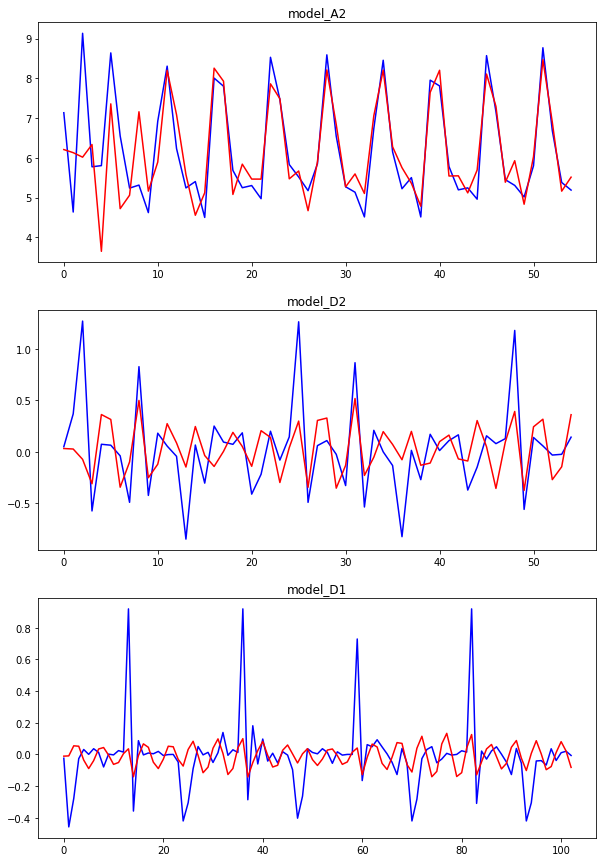

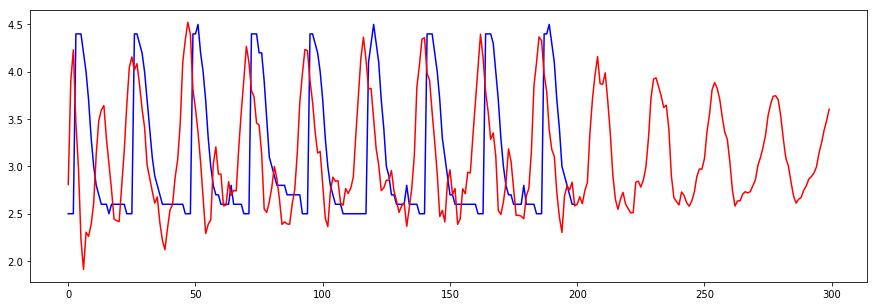

In [34]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pywt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import r2_score

#数据
dateparse = lambda dates: pd.datetime.strptime(dates,'%Y%m%d%H')

data = pd.read_csv(r'E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info\2018_config3_hourly_mem.csv',
                   encoding='UTF-8',parse_dates=['archour'],index_col = 'archour',date_parser=dateparse,nrows = 300)

index_list = np.array(data['maxvalue'])[:-100]
date_list1 = np.array(data['maxvalue'].index)[:-100]

index_for_predict = np.array(data['maxvalue'])[-100:]
date_list2 = np.array(data.index)[-100:]

#分解
A2,D2,D1 = pywt.wavedec(index_list,'db4',mode='sym',level=2)
coeff=[A2,D2,D1]

# 对每层小波系数求解模型系数
order_A2 = sm.tsa.arma_order_select_ic(A2,ic='aic')['aic_min_order']
order_D2 = sm.tsa.arma_order_select_ic(D2,ic='aic')['aic_min_order']
order_D1 = sm.tsa.arma_order_select_ic(D1,ic='aic')['aic_min_order']

# print order_A2,order_D2,order_D1

#对每层小波系数构建ARMA模型
model_A2 = ARMA(A2,order=order_A2)
model_D2 = ARMA(D2,order=order_D2)
model_D1 = ARMA(D1,order=order_D1)

results_A2 = model_A2.fit()
results_D2 = model_D2.fit()
results_D1 = model_D1.fit()

plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.plot(A2,'blue')
plt.plot(results_A2.fittedvalues,'red')
plt.title('model_A2')

plt.subplot(3,1,2)
plt.plot(D2,'blue')
plt.plot(results_D2.fittedvalues,'red')
plt.title('model_D2')

plt.subplot(3,1,3)
plt.plot(D1,'blue')
plt.plot(results_D1.fittedvalues,'red')
plt.title('model_D1')

A2_all,D2_all,D1_all = pywt.wavedec(np.array(data['maxvalue']),'db4',mode='sym',level=2)
delta = [len(A2_all)-len(A2),len(D2_all)-len(D2),len(D1_all)-len(D1)]

print (delta)

pA2 = model_A2.predict(params=results_A2.params,start=1,end=len(A2)+delta[0])
pD2 = model_D2.predict(params=results_D2.params,start=1,end=len(D2)+delta[1])
pD1 = model_D1.predict(params=results_D1.params,start=1,end=len(D1)+delta[2])

coeff_new = [pA2,pD2,pD1]
denoised_index = pywt.waverec(coeff_new,'db4')

plt.figure(figsize=(15,5))
plt.plot(index_list,'blue')
plt.plot(denoised_index,'red')

temp_data_wt = {'real_value':data['maxvalue'][-100:],'pre_value_wt':denoised_index[-100:]
               ,'err_wt':denoised_index[-100:]-index_for_predict
                ,'err_rate_wt/%':(denoised_index[-100:]-index_for_predict)/index_for_predict*100}
predict_wt = pd.DataFrame(temp_data_wt,index=date_list2,columns=['real_value','pre_value_wt','err_wt','err_rate_wt/%'])
print(predict_wt)
print(r2_score(data['maxvalue'][-100:],denoised_index[-100:]))


真实数据：qljungbox, pval, qboxpierce, pvalbp: 2273.221106393218 0.0 2271.0892954150436 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 3597.731014028954 0.0 3593.9430481178188 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 4140.759360201158 0.0 4136.122647265684 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 4265.345157933249 0.0 4260.474773604716 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 4265.370830135337 0.0 4260.500389631308 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 4340.780042836733 0.0 4335.721020369086 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 4561.992976793813 0.0 4556.311598463205 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 4897.855235242479 0.0 4891.123959261203 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 5307.195854925811 0.0 5299.057030705549 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 5754.562630181455 0.0 5744.745656132162 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 6225.328565466423 0.0 6213.598506966145 0.0
真实数据：qljungbox, pval, qboxpierce, pvalbp: 6699.35576

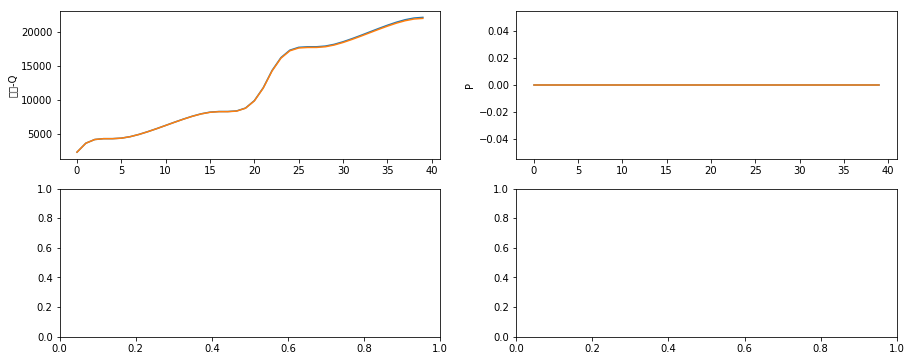

In [33]:
def boxpierce_test():
#     '''计算box pierce 和 box ljung统计量'''
    from statsmodels.sandbox.stats.diagnostic import acorr_ljungbox
    data = pd.read_csv(r'E:\HomeMadeSoftware\Cffex_Data_Analysis\output_data\cffex-host-info\2018_config3_hourly_mem.csv',
                   encoding='UTF-8',parse_dates=['archour'],index_col = 'archour',date_parser=dateparse)
    x=data['maxvalue']
    qljungbox, pval, qboxpierce, pvalbp=acorr_ljungbox(x, boxpierce=True)
    count = 0
    for i in range(len(pval)):
        if pval[i] > 0.5:
            count = count+1
        print('真实数据：qljungbox, pval, qboxpierce, pvalbp:',qljungbox[i], pval[i], qboxpierce[i], pvalbp[i])
    print (count)
    fig, axes = plt.subplots(2,2)
    axes[0,0].plot(qljungbox, label='qljungbox');axes[0,0].set_ylabel('真实-Q')
    axes[0,0].plot(qboxpierce, label='qboxpierce')
    axes[0,1].plot(pval, label='pval');axes[0,1].set_ylabel('P')
    axes[0,1].plot(pvalbp, label='pvalbp')
#     x=[random.randint(1, 200) for i in range(data.shape[0])]
#     qljungbox, pval, qboxpierce, pvalbp=acorr_ljungbox(x, boxpierce=True)
#     axes[1,0].plot(qljungbox, label='qljungbox');axes[1,0].set_ylabel('随机-Q')
#     axes[1,0].plot(qboxpierce, label='qboxpierce')
#     axes[1,1].plot(pval, label='pval');axes[1,1].set_ylabel('P')
#     axes[1,1].plot(pvalbp, label='pvalbp')
#     axes[0,0].legend()
#     axes[0,1].legend()
#     axes[1,0].legend()
#     axes[1,1].legend()
#     plt.savefig('../imgs/boxpierce_test.png')
    plt.show()
#     print('随机数据：qljungbox, pval, qboxpierce, pvalbp:',qljungbox, pval, qboxpierce, pvalbp)
if __name__=='__main__':
    boxpierce_test()